<font size="5">**Algorytmy danych geoprzestrzennych**</font><br>
<font size="4">Transformacje</font>

<font size="4">Krzysztof Dyba</font>

# Dane rastrowe

Dane rastrowe w systemach informacji geograficznej reprezentują przestrzeń geograficzną poprzez georeferencję, która składa się z:

- zakresu przestrzennego (określonego przez cztery współrzędne),
- rozdzielczości przestrzennej (np. metry na piksel),
- układu przestrzennego.

Znając te parametry możemy dokonać transformacji z układu rastra (definiowanego przez wiersze oraz kolumny) do układu geograficznego (definiowanego przez długość oraz szerokość geograficzną) w następujący sposób:

$$
x = \text{x_min} + (\text{column} + 0.5) \times \text{x_res}
$$

$$
y = \text{y_max} - (\text{row} + 0.5) \times \text{y_res}
$$

Można także przeprowadzić tę operację w drugą stronę, obliczając numer wiersza i kolumny na podstawie współrzędnych geograficznych:

$$
\text{column} = \text{floor} ( \frac{x - \text{x_min}}{\text{x_res}} )
$$

$$
\text{row} = \text{floor} ( \frac{\text{y_max} - y}{\text{y_res}} )
$$

Powyższe funkcje zakładają, że początek układu znajduje się w lewym górnym rogu.

# Dane wektorowe

Transformacje wektorowe to operacje matematyczne, które modyfikują geometrię obiektów. Zaliczamy do nich:

## Przesunięcie

Przesunięcie obiektu o określoną odległość w określonym kierunku (nie zmienia rozmiaru, kształtu ani orientacji obiektu).

$$
x' = x + \Delta x
$$

$$
y' = y + \Delta y
$$

## Przeskalowanie

Zmiana rozmiaru obiektu używając punkt obrotu oraz współczynnik skalowania. Współczynnik może być jednakowy w obu kierunkach lub różny (wtedy dodatkowo zmianie ulegnie kształt obiektu).

$$
x' = \Delta x \times (x - px) + px
$$

$$
y' = \Delta y \times (y - py) + py
$$

## Transpozycja

Zamiana współrzędnych X i Y obiektów.

$$
x' = y
$$

$$
y' = x
$$

## Odbicie

Odbicie obiektu przez określoną linię (oś odbicia), tworząc obraz lustrzany.

Odbicie pionowe, w którym $a$ to linia wertykalna:

$$
x' = 2a - x
$$

$$
y' = y
$$

Odbicie poziome, w którym $b$ to linia horyzontalna:

$$
x' = x
$$

$$
y' = 2b - y
$$

## Obrócenie

Obrócenie obiektu wokół określonego punktu (np. centroidu) o dany kąt $\theta$ wyrażony w radianach (zmienia orientację obiektu, ale zachowuje jego kształt i rozmiar).

$$
\theta = -\frac{\theta \times \pi}{180}
$$

$$
x' = (x - px) \times \cos(\theta) - (y - py) \times \sin(\theta) + px
$$

$$
y' = (x - px) \times \sin(\theta) + (y - py) \times \cos(\theta) + py
$$

# Przykład

Spróbujmy stworzyć prostą funkcję `shift()`, która pozwoli przesunąć geometrię o zadane współrzędne X (`dx`) i Y (`dy`). Jako wejście wykorzystajmy reprezentacje WKT. Najistotniejszym zadaniem jest przesunięcie każdego wierzchołka o określoną odległość, do czego niezbędne jest zastosowanie pętli. Aby odwołać się do wierzchołków należy wykorzystać metodę `vertices()`. Ostatni etap działa funkcji związany jest z odtworzeniem właściwej geometrii linii lub poligonu i zwrócenie wyniku.

In [1]:
def shift(wkt, dx, dy):
    from qgis.core import QgsGeometry, QgsPointXY
    
    geometry = QgsGeometry.fromWkt(wkt)
    geom_type = geometry.type().name
    vertices = geometry.vertices()
    
    shifted = []
    for vertex in vertices:
        new_x = vertex.x() + dx
        new_y = vertex.y() + dy
        shifted.append(QgsPointXY(new_x, new_y))
    
    if geom_type == "Point":
        return shifted
    elif geom_type == "Line":
        new_geom = QgsGeometry.fromPolylineXY(shifted)
    elif geom_type == "Polygon":
        new_geom = QgsGeometry.fromPolygonXY([shifted])
    else:
        raise ValueError("Nieobsługiwana geometria!")
    
    return new_geom

In [2]:
poly = "POLYGON ((40 30, 60 30, 50 40, 40 30))"
poly_shift = shift(poly, dx = 10, dy = 5)
print(poly_shift)

<QgsGeometry: Polygon ((50 35, 70 35, 60 45, 50 35))>


W kolejnym kroku możemy wyświetlić zmodyfikowaną geometrię używając biblioteki `matplotlib`. Jednak, uprzednio musimy zdefiniować pomocniczą funkcję, która posłuży do konwersji obiektu `QgsGeometry` (lub WKT) do współrzędnych zapisanych jako listy z liczbami.

In [3]:
def geometry_to_coords(geometry):
    from qgis.core import QgsGeometry
    
    # przypadek geometrii z WKT
    if isinstance(geometry, str):
        geometry = QgsGeometry.fromWkt(geometry)
    
    geom_type = geometry.type().name
    
    if geom_type == "Point":
        x, y = geometry.asPoint()
    elif geom_type == "Line":
        points = geometry.asPolyline()
        x, y = zip(*points)
    elif geom_type == "Polygon":
        points = geometry.asPolygon()
        for p in points:
            x, y = zip(*p)
    else:
        raise ValueError("Nieobsługiwana geometria!")
    
    return x, y

Teraz wyświetlmy obie geometrie.

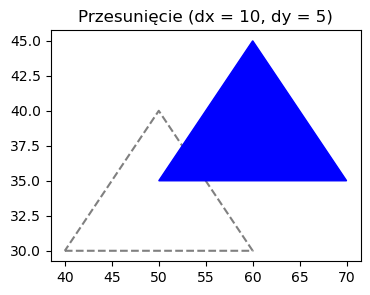

In [4]:
import matplotlib.pyplot as plt

x1 = geometry_to_coords(poly)[0]
y1 = geometry_to_coords(poly)[1]
x2 = geometry_to_coords(poly_shift)[0]
y2 = geometry_to_coords(poly_shift)[1]

plt.figure(figsize = (4, 3))
plt.plot(x1, y1, color = "grey", linestyle = "dashed", zorder = 1)
plt.fill(x2, y2, color = "blue", zorder = 2)
plt.title("Przesunięcie (dx = 10, dy = 5)")
plt.show()

# Zadania:

17) Napisz funkcje `xy_from_colrow()` oraz `colrow_from_xy()`, które umożliwią transformację kolumn i wierszy na współrzędne geograficzne oraz transformację w drugą stronę. Uwzględnij warunek sprawdzający czy szukane parametry znajdują się w zakresie rastra, tj. nie wychodzą poza jego zasięg.
18) Zaimplementuj dwie wybrane operacje transformacji geometrii, a następnie wyświetl ich wyniki. Jako przykładowe dane wykorzystaj poligon `"POLYGON ((40 30, 60 30, 50 40, 40 30))"`.